## 01. Pytorch Workflow Fundamentals

### 1. Importing Necessary Libraries and Setting up the device

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'2.8.0'

In [2]:
get_device = lambda: "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

device = get_device()
print(device)

mps


### 2. Data

In [3]:
# create weight and bias
weight = 0.4
bias = 0.8

start = 1
end = 5
step = 0.07

# create X and y (features and labels)
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight*X + bias
X[:10], y[:10]

(tensor([[1.0000],
         [1.0700],
         [1.1400],
         [1.2100],
         [1.2800],
         [1.3500],
         [1.4200],
         [1.4900],
         [1.5600],
         [1.6300]]),
 tensor([[1.2000],
         [1.2280],
         [1.2560],
         [1.2840],
         [1.3120],
         [1.3400],
         [1.3680],
         [1.3960],
         [1.4240],
         [1.4520]]))

In [4]:
# Split the data
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(46, 46, 12, 12)

In [5]:
# Lets visualize them, to make sure they look okay

def plot_predictions(train_data = X_train,
                    train_labels = y_train,
                    test_data = X_test,
                    test_labels = y_test,
                    predictions = None):
    plt.figure(figsize=(10,7))
    plt.scatter(train_data, train_labels, c="b", s=4, label="training data")
    plt.scatter(test_data, test_labels, c='g', s=4, label="testing data")
    if predictions is not None:
        plt.scatter(test_data, predictions, c='r', s=4, label="predictions")

    # show legend
    plt.legend(prop={"size": 14})


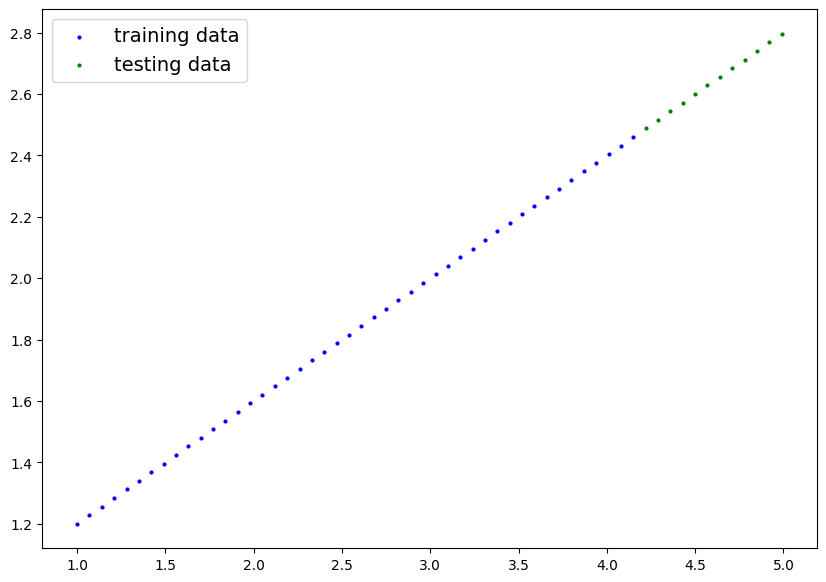

In [6]:
plot_predictions()

### 2. Build Model

In [12]:
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer = nn.Linear(in_features=1, out_features=1)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

In [13]:
torch.manual_seed(42)
model_1 = LinearRegressionModel()
model_1, model_1.state_dict()

(LinearRegressionModel(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [14]:
model_1.to(device)
next(model_1.parameters()).device

device(type='mps', index=0)

### 3. Training

In [15]:
# Defining the loss function and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.01)


In [16]:
# Pytorch training loop
torch.manual_seed(42)
epochs = 1000

# Put the data on the available device
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
    # training
    model_1.train()
    y_pred = model_1(X_train)
    loss = loss_fn(y_pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Testing loop
    model_1.eval()
    with torch.inference_mode():
        test_pred = model_1(X_test)
        test_loss = loss_fn(test_pred, y_test)
        if(epoch % 10 == 0):
            print(f"Epoch: {epoch} | Train Loss: {loss} | Test loss: {test_loss}")


Epoch: 0 | Train Loss: 0.9686946272850037 | Test loss: 1.5801293849945068
Epoch: 10 | Train Loss: 0.20563267171382904 | Test loss: 0.29434239864349365
Epoch: 20 | Train Loss: 0.023678680881857872 | Test loss: 0.06284844875335693
Epoch: 30 | Train Loss: 0.019741125404834747 | Test loss: 0.07348664849996567
Epoch: 40 | Train Loss: 0.028221506625413895 | Test loss: 0.12094771862030029
Epoch: 50 | Train Loss: 0.018440278246998787 | Test loss: 0.1256103217601776
Epoch: 60 | Train Loss: 0.02091972716152668 | Test loss: 0.12817898392677307
Epoch: 70 | Train Loss: 0.017811067402362823 | Test loss: 0.13305285573005676
Epoch: 80 | Train Loss: 0.017811067402362823 | Test loss: 0.13305285573005676
Epoch: 90 | Train Loss: 0.017811067402362823 | Test loss: 0.13305285573005676
Epoch: 100 | Train Loss: 0.017811067402362823 | Test loss: 0.13305285573005676
Epoch: 110 | Train Loss: 0.017811067402362823 | Test loss: 0.13305285573005676
Epoch: 120 | Train Loss: 0.017811067402362823 | Test loss: 0.13305285

In [17]:

print(model_1.state_dict())

OrderedDict([('linear_layer.weight', tensor([[0.4110]], device='mps:0')), ('linear_layer.bias', tensor([0.7539], device='mps:0'))])


### Making Predictions


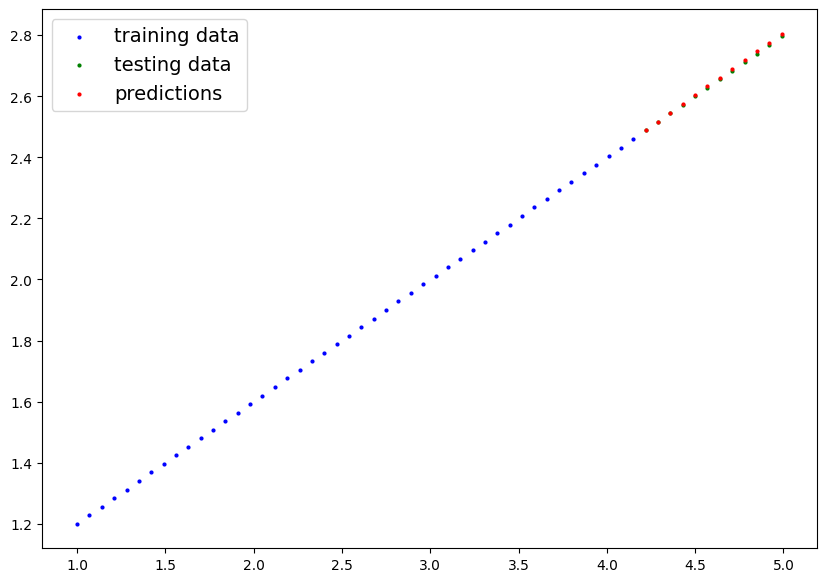

In [19]:
model_1.eval()
with torch.inference_mode():
    y_preds = model_1(X_test)

plot_predictions(predictions=y_preds.cpu())

### 5. Saving and Loading a Model


In [21]:
from pathlib import Path

# Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# Create model save path
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_1.pth


In [22]:
# Loading the model
loaded_model_1 = LinearRegressionModel()
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

loaded_model_1.to(device)
print(f"Loaded model: \n{loaded_model_1}")
print(f"Model on device: \n{next(loaded_model_1.parameters()).device}")

Loaded model: 
LinearRegressionModel(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)
Model on device: 
mps:0


tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='mps:0')

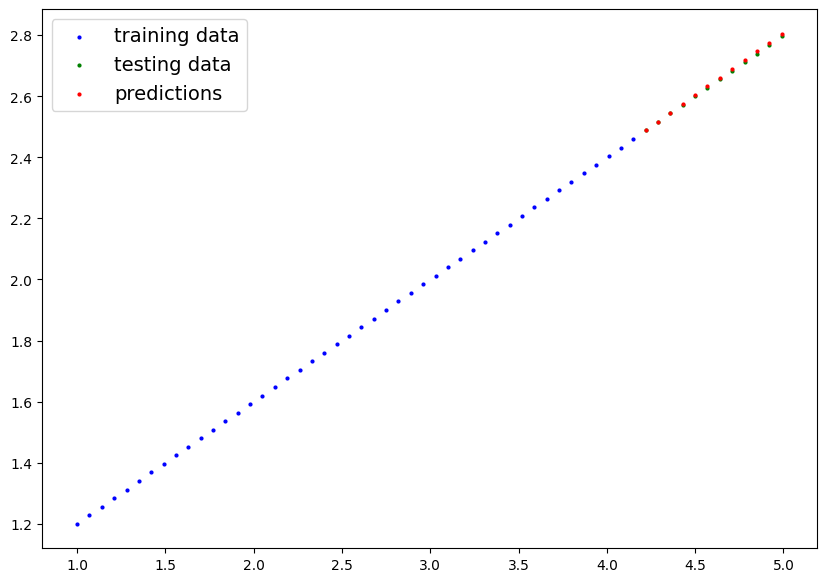

In [25]:
# Evaluate loaded model
loaded_model_1.eval()
with torch.inference_mode():
    loaded_model_1_preds = loaded_model_1(X_test)

plot_predictions(predictions=loaded_model_1_preds.cpu())
y_preds == loaded_model_1_preds